# Denoised and Pick DAS

This notebook test the ensemble deep learning picker from Yuan et al, 2023 on DAS data, whether it is raw data or denoised using MAE.

Marine Denolle 
Qibin Shi

Import modules

In [2]:
import sys
sys.path.append("../src/denoiser/")
sys.path.append("../models/")

import gc
import h5py
import torch
import numpy as np
import torch.nn as nn



from das_util import try_gpu
from matplotlib import pyplot as plt
from numpy.random import default_rng
from scipy.signal import filtfilt, butter
from torch.utils.data import DataLoader
from das_denoise_models import unet, dataflow, datalabel
from das_denoise_training import train_augmentation
from sklearn.model_selection import train_test_split

## Get the data

where is the data ?

In [14]:
! du -sh /fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023*

8.3G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_07_22.hdf5
3.8G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_07_29.hdf5
5.2G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_08_12.hdf5
5.4G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_08_16.hdf5
11G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_08_18.hdf5
24G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_11_02.hdf5


### Prepare and read Data

In [4]:
sampling_rate = 25 # number of points per second
dchan = 10 # channel spacing in mebers
chan_max = 4500  # maximum channel to trim the data

In [5]:
### Read (change the file to the latest if needed)
data_terra = '/fd1/QibinShi_data/akdas/qibin_data/TERRAtill2023_07_29.hdf5'
data_kkfls = '/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_07_29.hdf5'
with h5py.File(data_terra, 'r') as f:
    quake1 = f['quake'][:]
with h5py.File(data_kkfls, 'r') as f:
    quake2 = f['quake'][:]
    
# combine both arrays
rawdata = np.append(quake2[:,:chan_max,:], quake1[:,:chan_max,:], axis=0)

In [10]:
print(rawdata.shape)
print(f'there are  {rawdata.shape[0]:d}  events, for {rawdata.shape[1]:d} channels, and {rawdata.shape[2]:d} samples in time')

(180, 4500, 1500)
there are  180  events, for 4500 channels, and 1500 samples in time


### Filter data & normalize

In [11]:
### Filter
b, a = butter(4, (0.5, 12), fs=sampling_rate, btype='bandpass')
filtered_data = filtfilt(b, a, rawdata, axis=2)
filtered_data_norm = filtered_data / np.std(filtered_data, axis=(1,2), keepdims=True)  ## standard scaling

Plot the data .  Take the example of the 5th event

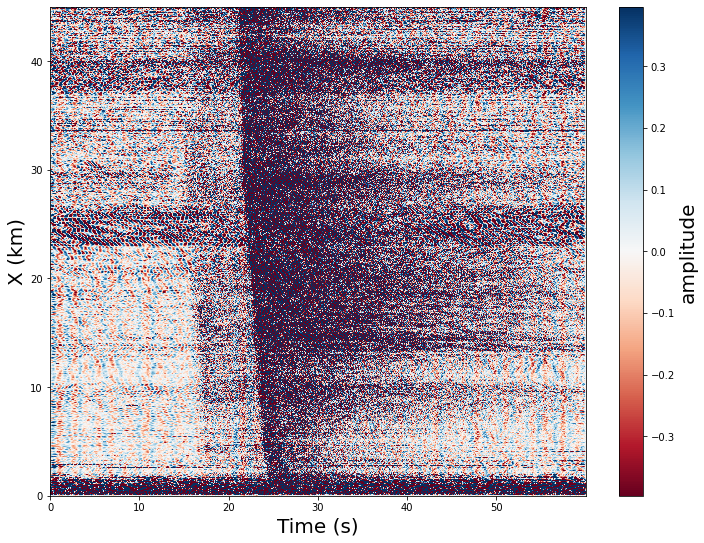

In [12]:
### visualize example data
time_data = filtered_data_norm[5]
max_amp = np.median(np.fabs(time_data))*2
x, y=np.arange(time_data.shape[1]), np.arange(time_data.shape[0])

plt.figure(figsize=(12, 9)); cmap=plt.cm.get_cmap('RdBu')
plt.pcolormesh(x, y, time_data, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
plt.xticks(np.arange(0, 1500, 250), np.arange(0, 1500/sampling_rate, 250/sampling_rate).astype(int))
plt.yticks(np.arange(0, chan_max, 1000), (np.arange(0, dchan*chan_max, 1000*dchan)/1000).astype(int))
plt.xlabel("Time (s)", fontsize=20); plt.ylabel("X (km)", fontsize=20)
cbr=plt.colorbar(); cbr.set_label('amplitude', fontsize = 20)

# 3. Load U-net models trained in different ways

In [13]:
""" Initialize the U-net model """
devc = try_gpu(i=0)

# U-net trained on pure raw (scaled) data (input and output)
model_1 = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_1 = nn.DataParallel(model_1, device_ids=[0,1,2,3])
model_1.to(devc)
model_1.load_state_dict(torch.load('../models/checkpoint_noatt_LRdecays0.8_mask0.3.pt'))  # raw2raw
model_1.eval() 

# U-net trained on raw input data and FK filtered output data
model_2 = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_2 = nn.DataParallel(model_2, device_ids=[0,1,2,3])
model_2.to(devc)
model_2.load_state_dict(torch.load('../models/checkpoint_noatt_LRdecays0.8_mask0.5_fk2fk.pt'))  # fk2fk
model_2.eval() 

# U-net trained on raw data input and FK-filtered data ouput.
model_3 = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_3 = nn.DataParallel(model_3, device_ids=[0,1,2,3])
model_3.to(devc)
model_3.load_state_dict(torch.load('../models/checkpoint_noatt_LRdecays0.8_mask0.5_raw2fk.pt'))  # raw2fk
model_3.eval() 

DataParallel(
  (module): unet(
    (relu): ReLU()
    (layer): ModuleList(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): MaxBlurPool2d()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): MaxBlurPool2d()
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): MaxBlurPool2d()
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): Dropout(p=0.2, inplace=False)
      (12): MaxBlurPool2d()
      (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1

### Prepare data to be denoised

The data input is 1500 points, 1500 channels. For deploying this denoiser, enter the entire image (not masked).

In [26]:
### convert to torch tensors
X = filtered_data_norm[:100,np.newaxis,500:2000,:]
X = torch.from_numpy(X).to(devc)
print(X.shape)

torch.Size([100, 1, 1500, 1500])


Deploy denoise

In [27]:
### denoise - deploy
with torch.no_grad():
    ### raw2raw
    oneDenoise_1 = model_1(X)
    mulDenoise_1 = model_1(oneDenoise_1)
    mulDenoise_1 = model_1(mulDenoise_1)
    mulDenoise_1 = model_1(mulDenoise_1)

    ### fk2fk
    oneDenoise_2 = model_2(X)
    mulDenoise_2 = model_2(oneDenoise_2)
    mulDenoise_2 = model_2(mulDenoise_2)
    mulDenoise_2 = model_2(mulDenoise_2)

    ### raw2fk
    oneDenoise_3 = model_3(X)
    mulDenoise_3 = model_3(oneDenoise_3)

### convert back to numpy, trim edges
wid_edge = 125
rawdata = X.to('cpu').numpy()[:,:,:,wid_edge:-wid_edge]
oneDenoise_1 = oneDenoise_1.to('cpu').numpy()[:,:,:,wid_edge:-wid_edge]
oneDenoise_2 = oneDenoise_2.to('cpu').numpy()[:,:,:,wid_edge:-wid_edge]
oneDenoise_3 = oneDenoise_3.to('cpu').numpy()[:,:,:,wid_edge:-wid_edge]
mulDenoise_1 = mulDenoise_1.to('cpu').numpy()[:,:,:,wid_edge:-wid_edge]
mulDenoise_2 = mulDenoise_2.to('cpu').numpy()[:,:,:,wid_edge:-wid_edge]
mulDenoise_3 = mulDenoise_3.to('cpu').numpy()[:,:,:,wid_edge:-wid_edge]

### save denoised data to file
with h5py.File('/fd1/QibinShi_data/akdas/qibin_data/' + 'test_marine.hdf5', 'w') as f:
    f.create_dataset("raw", data=rawdata)
    f.create_dataset("raw2raw_oneDenoise", data=oneDenoise_1)
    f.create_dataset("fk2fk_oneDenoise", data=oneDenoise_2)
    f.create_dataset("raw2fk_oneDenoise", data=oneDenoise_3)
    f.create_dataset("raw2raw_mulDenoise", data=mulDenoise_1)
    f.create_dataset("fk2fk_mulDenoise", data=mulDenoise_2)
    f.create_dataset("raw2fk_mulDenoise", data=mulDenoise_3)

RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/jupyter_share/anaconda3/envs/seismo/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/home/jupyter_share/anaconda3/envs/seismo/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/mdenolle/Denoise_and_Pick/Shi_etal_2023_denoiseDAS/examples/../src/denoiser/das_denoise_models.py", line 68, in forward
    x = self.layer[3 * i + 0](x)  # conv1
  File "/home/jupyter_share/anaconda3/envs/seismo/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/jupyter_share/anaconda3/envs/seismo/lib/python3.8/site-packages/torch/nn/modules/conv.py", line 463, in forward
    return self._conv_forward(input, self.weight, self.bias)
  File "/home/jupyter_share/anaconda3/envs/seismo/lib/python3.8/site-packages/torch/nn/modules/conv.py", line 459, in _conv_forward
    return F.conv2d(input, weight, bias, self.stride,
RuntimeError: Input type (double) and bias type (float) should be the same
